# DSCI 100 Project Final Report 008-17: What Time Windows are Likely to Have Large Numbers of Players?

## Introduction
Background: A group in Computer Science at UBC is interested in understanding how people play video games. They have set up a server running MineCraft and are recording play sessions. The server is called PlaiCraft.

Our project focuses on the second question: What time windows are most likely to have large numbers of simultaneous players? This insight is critical for demand forecasting to ensure that we maintain a sufficient number of licenses to accommodate all players concurrently with a high probability. 

Our analysis will involve finding suitable predictor variables for the number of simultaneous players at a given time, our response variable. Specifically, can `month`, `day_of_week`, `hour`, `experience`, and `session_duration` accurately predict the number of simultaneous players (`player_count`) over a 1-hour time window using K-NN regression?

We will calculate `month`, `day_of_week`, `hour`, and `session_duration` from `start_time` and `end_time`, and `player_count` using 1-hour time windows over the time range in the data.

Note: we are not using `age`, `subscribe`, or `gender` because they are unreliable - many participants lie about their age and gender and subscribe is unlikely to be indicative of play time.

## Methods & Results

### Data Wrangling

The analysis began by loading the player and session datasets from provided URLs. The `start_time` and `end_time` columns were converted to the `POSIXct` format using the `lubridate::dmy_hm()` function to enable effective time-based analysis. Unnecessary columns, such as `individualId` and `organizationName` from the player dataset and `original_start_time` and `original_end_time` from the session dataset, were removed to streamline the data. Missing values were identified and handled using the `select_if` function to pinpoint columns containing `NA` values.

### Feature Engineering

To facilitate the analysis, time-based features were engineered by creating `time_windows`, grouping session data into hourly intervals. This was done using the `seq()`, `floor_date()`, and `ceiling_date()` functions. Aggregated data was then computed by `time_window`, producing metrics such as `player_count`, `most_frequent_experience`, and `total_session_duration`. Categorical variables, including `month`, `day_of_week`, and `experience`, were directly encoded as numeric values. This was done to avoid the issues associated with one-hot encoding, which resulted in columns with zero variance due to constant predictors in subsets of the data. Direct conversion to numbers ensured that no columns with zero variance were created, thus maintaining meaningful predictive features.

### KNN Regression

The dataset was split into training (80%) and test (20%) sets using the `initial_split()` function from the `rsample` package. A KNN regression model was then defined using the `nearest_neighbor()` function with the `kknn` engine, and the number of neighbors (`K`) was set to be tuned. A 5-fold cross-validation strategy was employed via the `vfold_cv()` function to evaluate model performance.

Forward selection was used to iteratively add predictors to the model, with the goal of minimizing the **Root Mean Squared Error (RMSE)**. The number of neighbors (`K`) was tuned between 2 and 50 for each feature subset using the `tune_grid()` function, with the best `K` value identified for each combination of predictors. To avoid the "`estimate` is constant and has 0 standard deviation" warning, the tuning started at `K = 2`, as `K = 1` was found to be unstable and relied solely on the nearest neighbor.

### Model Selection and Evaluation

The model was selected based on the minimum **RMSE** obtained from the forward selection process. Both the optimal set of predictors and the corresponding `K` were recorded. The final model was fitted using the selected predictors and optimal `K`. It was then evaluated on the test set using three performance metrics: **RMSE**, **R-squared (R²)**, and **Mean Absolute Error (MAE)**.

### Results

The forward selection process identified **total_session_duration**, **most_frequent_experience**, and **hour** as the key predictors for the model. The final model achieved reasonable performance metrics, with **RMSE** of 1.03, **R²** of 0.358, and **MAE** of 0.633. While the performance is reasonable, there remains considerable room for improvement.

### Exploratory Data Analysis and Visualization


In [13]:
library(repr)
library(tidyverse)
library(tidymodels)

In [14]:
set.seed(123) # set seed for reproducibility

# show dataset can be loaded into R
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
sessions_url <- "https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB"

players <- read_csv(players_url)
sessions <- read_csv(sessions_url)

head(players)
head(sessions)

# get names of columns with missing/NA values (for data description)
players_na_cols <- players |>
    select_if(~ any(is.na(.))) |>
    names()
players_na_cols

sessions_na_cols <- sessions |>
    select_if(~ any(is.na(.))) |>
    names()
sessions_na_cols

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


[1] "individualId"     "organizationName"

[1] "end_time"          "original_end_time"

In [15]:
# individualId and organizationName not needed b/c they are empty
# data is already tidy - each row is a single observation (unique player), each column is a single variable, each value is a single cell
players_tidy <- select(players, -individualId, -organizationName)
head(players_tidy)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [16]:
# digits given in original_start_time and original_end_time are not specific enough to get any difference between the 2 columns, can remove
# data is already tidy - each row is a single observation (play session), each column is a single variable, each value is a single cell
sessions_tidy <- sessions |>
    select(-original_start_time, -original_end_time) |>
    mutate(
        start_time = dmy_hm(start_time), # convert to POSIXct using lubridate::dmy_hm()
        end_time = dmy_hm(end_time)
        )
head(sessions_tidy)

hashedEmail,start_time,end_time
<chr>,<dttm>,<dttm>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00


## Data Description
### players.csv
- Number of observations: 196
- Number of variables: 9
| Variable   | Description                | Data Type | Example Value   |
|------------|----------------------------|-----------|-----------------|
| `experience` | Player's experience level (e.g. Beginner, Amateur, etc.)      | Categorical (factor)    | `Pro`    |
| `subscribe`      | Whether player has subscribed to PlaiCraft's email updates    | logical   | `TRUE`            |
| `hashedEmail` | Unique hashed email identifier for player | character   | `f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d`          |
| `played_hours`  | Total play time in hours     | double     | `30.3`       |
| `name`| Player's name | character  | `Morgan` |
| `gender`| Player's gender (e.g. Male, Female, etc.) | Categorical (factor)  | `Male` |
| `age`| Player's age in years | integer  | `9` |
| `individualId`| No values provided | N/A  | `NA` |
| `organizationName`| No values provided | N/A  | `NA` |

### sessions.csv
- Number of observations: 1,535
- Number of variables: 5
| Variable   | Description                | Data Type | Example Value   |
|------------|----------------------------|-----------|-----------------|
| `hashedEmail` | Unique hashed email identifier for player | character   | `bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf`          |
| `start_time`      | Start timestamp of the play session (DD/MM/YYYY HH:MM)    | date-time (dttm)   | `30/06/2024 18:12`            |
| `end_time` | End timestamp of the play session (DD/MM/YYYY HH:MM) | date-time (dttm)   | `30/06/2024 18:24`          |
| `original_start_time`  | Scheduled start time in UNIX timestamp format     | double     | `1.71977E+12`       |
| `original_end_time`| Scheduled end time in UNIX timestamp format | double  | `1.71977E+12` |

### Potential Issues
- `individualId` and `organizationName` have no values; `end_time` and `original_end_time` have missing values
- Need to check if all `hashedEmail` values match across the CSV files; only the matches will have data from both CSV files
- Must verify that all timestamps are correct i.e. end times come after start times and the DD/MM/YYYY HH:MM values match the UNIX timestamp values
- Not enough digits in `original_start_time` and `original_end_time` to see any difference between them

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


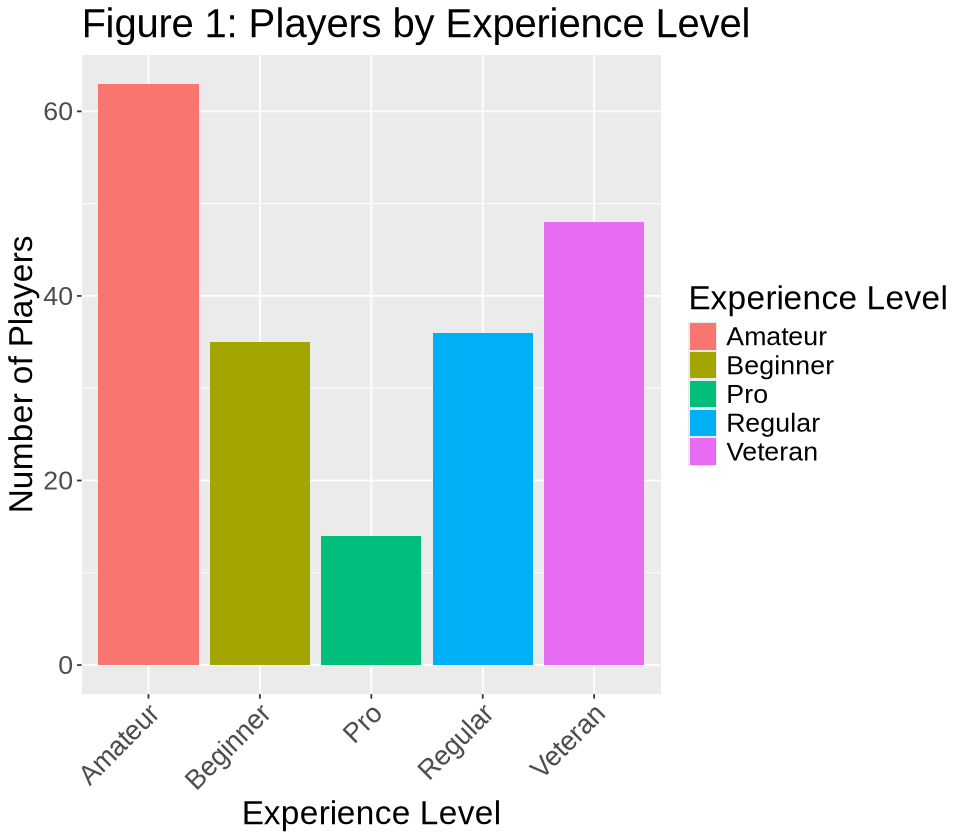

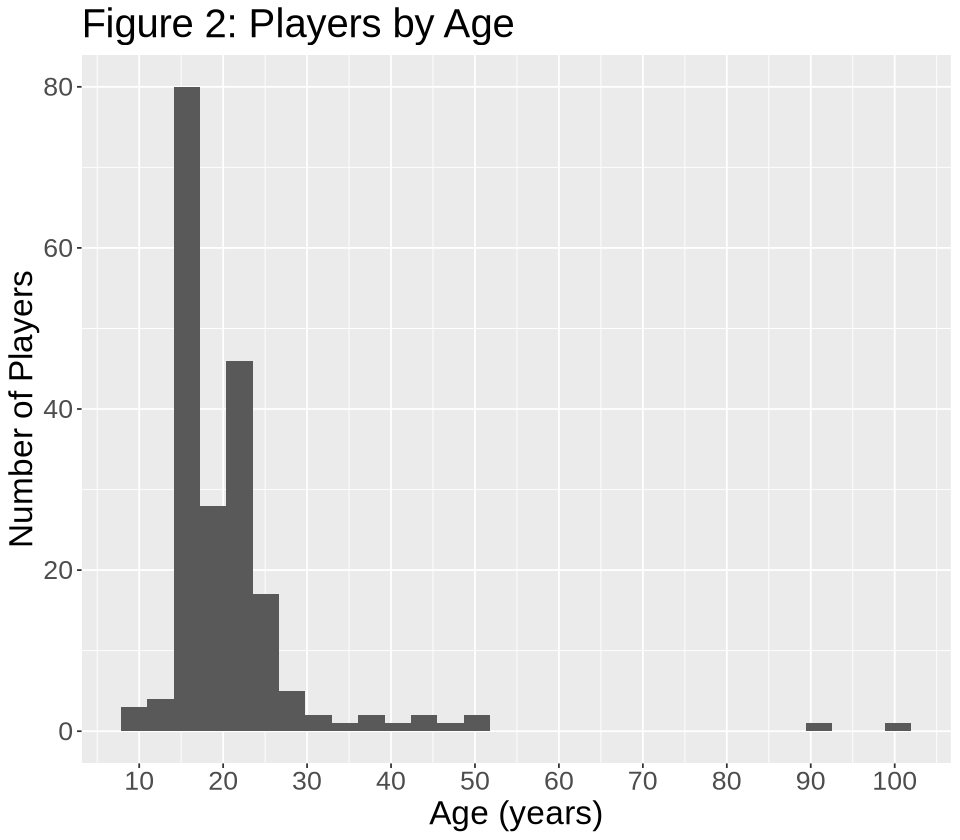

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_summary()`).”


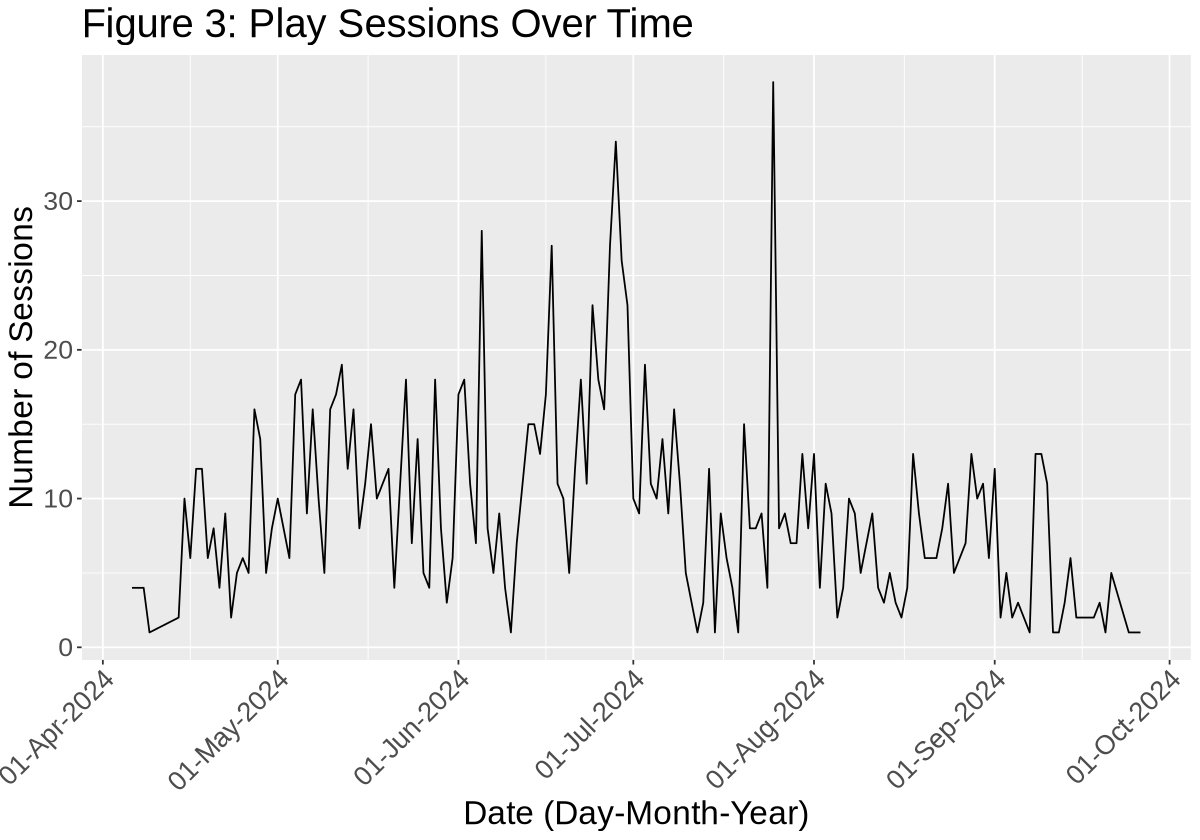

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


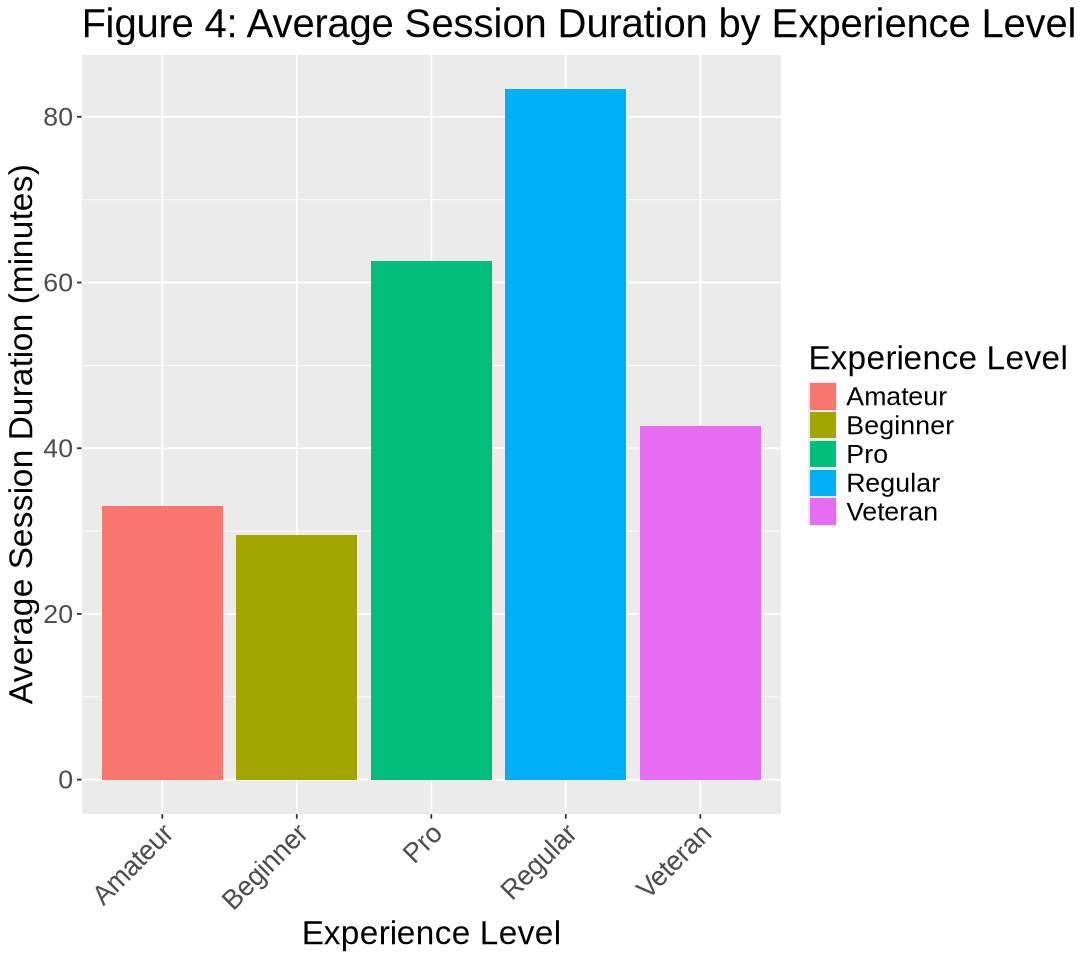

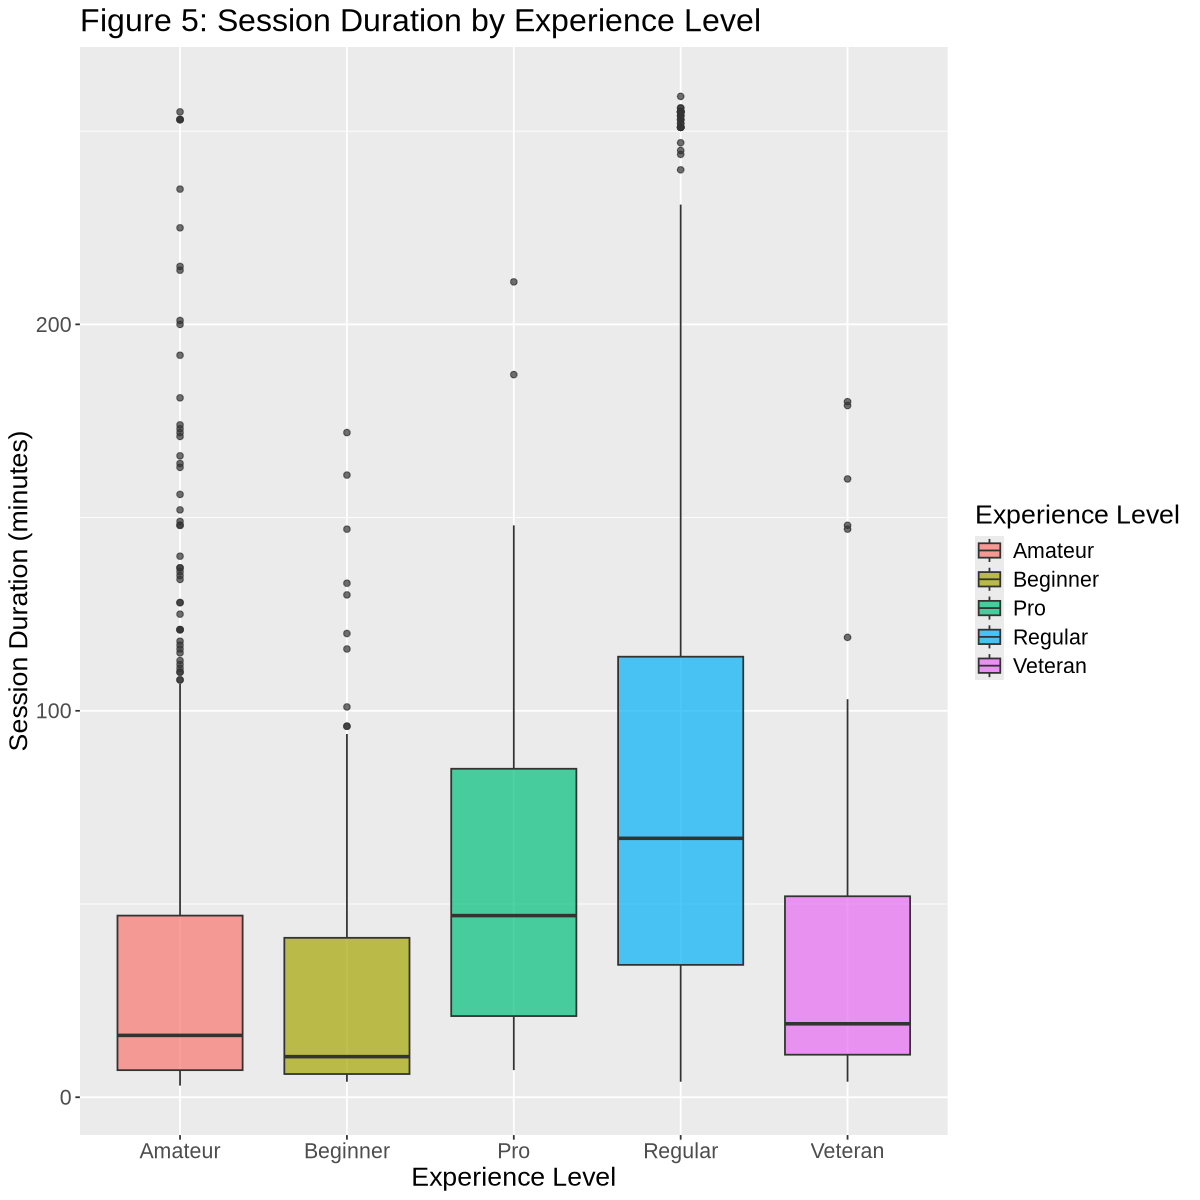

In [33]:
# Visualizations
# Distribution of players by experience level plot
options(repr.plot.width = 8, repr.plot.height = 7)
players_by_exp_plot <- ggplot(players_tidy, aes(x = experience)) +
  geom_bar(aes(fill = experience)) + 
  labs(
    title = "Figure 1: Players by Experience Level",
    x = "Experience Level",
    y = "Number of Players",
    fill = "Experience Level"
  ) +
  theme(
      text = element_text(size = 20),
      axis.text.x = element_text(angle = 45, hjust = 1)
  )
players_by_exp_plot

# Distribution of players by age plot
players_by_age_plot <- ggplot(players_tidy, aes(x = age)) +
  geom_histogram() + 
  labs(
    title = "Figure 2: Players by Age",
    x = "Age (years)",
    y = "Number of Players"
  ) +
  scale_x_continuous(
    breaks = seq(0, 100, by = 10)  
  ) +
  theme(text = element_text(size = 20)) +
  theme(legend.position = "none")  # Removed legend
players_by_age_plot

# Sessions over time plot
options(repr.plot.width = 10, repr.plot.height = 7)
session_counts <- sessions_tidy |>
    mutate(start_date = as.Date(start_time)) |>
    group_by(start_date) |>
    summarise(session_count = n())

sessions_time_plot <- ggplot(session_counts, aes(x = start_date, y = session_count)) +
  geom_line() +  
  labs(
    title = "Figure 3: Play Sessions Over Time",
    x = "Date (Day-Month-Year)",
    y = "Number of Sessions"
  ) +
  theme(
      text = element_text(size = 20),
      axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  scale_x_date(
    date_labels = "%d-%b-%Y",  
    date_breaks = "1 month"     
  ) +
  theme(legend.position = "none")  # Removed legend
sessions_time_plot

# Average session duration by experience level plot
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
    session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  )

options(repr.plot.width = 9, repr.plot.height = 8)
avg_session_exp_plot <- ggplot(sessions_players_joined, aes(x = experience, y = session_duration)) +
  geom_bar(stat = "summary", fun = "mean", aes(fill = experience)) +  
  labs(
    title = "Figure 4: Average Session Duration by Experience Level",
    x = "Experience Level",
    y = "Average Session Duration (minutes)",
    fill = "Experience Level"
  ) +
  theme(text = element_text(size = 20),
       axis.text.x = element_text(angle = 45, hjust = 1))
avg_session_exp_plot

options(repr.plot.width = 10, repr.plot.height = 10)
session_duration_exp_plot <- ggplot(sessions_players_joined, aes(x = experience, y = session_duration, fill = experience)) +
  geom_boxplot(alpha = 0.7) +
  labs(
    title = "Figure 5: Session Duration by Experience Level",
    x = "Experience Level",
    y = "Session Duration (minutes)",
    fill = "Experience Level"
  ) +
  theme(text = element_text(size = 16))
session_duration_exp_plot


### Relevant Insights
- Players by Age histogram shows a skewed distribution with most players between ages 10 and 25, suggesting the relationship between age and other variables may not be linear
- Play Sessions Over Time line plot oscillates wildly, appears non-linear
- Significant outliers are present in all experience levels

In [18]:
# left join using hashedEmail
sessions_players_joined <- left_join(sessions_tidy, players_tidy, by = "hashedEmail") |>
  mutate(
	session_duration = as.numeric(difftime(end_time, start_time, units = "mins"))
  ) |>
	filter(!is.na(end_time)) # filter out any rows with NA values

head(sessions_players_joined)

time_windows <- data.frame(
  time_window = seq(from = floor_date(min(sessions_players_joined$start_time), "hour"),
                	to = ceiling_date(max(sessions_players_joined$end_time), "hour"),
                	by = "hour")
)
head(time_windows)

# perform a cross join between sessions and time windows
player_counts <- time_windows |>
  # use expand_grid to generate all combinations of time_window and sessions
  expand_grid(session = sessions_players_joined) |>
  # filter for sessions that overlap with the time window
  filter(session$start_time < time_window + hours(1) & session$end_time > time_window) |>
  # group by time_window to get player count, most frequent experience level, and total session duration
  group_by(time_window) |>
  summarise(
	player_count = n(),  # count number of sessions overlapping the time window
	most_frequent_experience = names(sort(table(session$experience), decreasing = TRUE))[1],  # Most frequent experience level
	total_session_duration = sum(session$session_duration, na.rm = TRUE),  # Sum of session durations
	.groups = "drop"
  ) |>
	mutate(
	month = month(time_window, label = TRUE),  	# month (Jan, Feb, ..., Dec)
	day_of_week = wday(time_window, label = TRUE),  # day of the week (Mon, Tue, ..., Sun)
	hour = hour(time_window)                  	# hour (0-23)
  )

head(player_counts)

# Directly converted categorical variables to numbers to avoid the zero variance issues
player_counts_numeric <- player_counts |>
  mutate(
	# Map months to numeric values (Jan=1, Feb=2, ..., Dec=12)
	month = recode(month,
                    	Jan = 1,
                    	Feb = 2,
                    	Mar = 3,
                    	Apr = 4,
                    	May = 5,
                    	Jun = 6,
                    	Jul = 7,
                    	Aug = 8,
                    	Sep = 9,
                    	Oct = 10,
                    	Nov = 11,
                    	Dec = 12),
    
	# Map days of the week to numeric values (Mon=1, Tue=2, ..., Sun=7)
	day_of_week = as.numeric(factor(day_of_week, levels = c("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"))),
    
	# Map experience levels to numeric values (Beginner=1, Amateur=2, Regular=3, Pro=4, Veteran=5)
	most_frequent_experience = as.numeric(factor(most_frequent_experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")))
  ) |> select(-time_window)

head(player_counts_numeric)

hashedEmail,start_time,end_time,experience,subscribe,played_hours,name,gender,age,session_duration
<chr>,<dttm>,<dttm>,<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,Regular,TRUE,223.1,Hiroshi,Male,17,12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,Amateur,TRUE,53.9,Alex,Male,17,13
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,Amateur,TRUE,150.0,Delara,Female,16,23
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,Regular,TRUE,223.1,Hiroshi,Male,17,36
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,Amateur,TRUE,53.9,Alex,Male,17,11
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,Regular,TRUE,223.1,Hiroshi,Male,17,122


,time_window
,<dttm>
1,2024-04-06 09:00:00
2,2024-04-06 10:00:00
3,2024-04-06 11:00:00
4,2024-04-06 12:00:00
5,2024-04-06 13:00:00
6,2024-04-06 14:00:00


time_window,player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<dttm>,<int>,<chr>,<dbl>,<ord>,<ord>,<int>
2024-04-06 09:00:00,2,Amateur,45,Apr,Sat,9
2024-04-06 10:00:00,1,Amateur,41,Apr,Sat,10
2024-04-06 20:00:00,1,Amateur,68,Apr,Sat,20
2024-04-06 21:00:00,1,Amateur,68,Apr,Sat,21
2024-04-06 22:00:00,2,Amateur,137,Apr,Sat,22
2024-04-06 23:00:00,1,Pro,69,Apr,Sat,23


player_count,most_frequent_experience,total_session_duration,month,day_of_week,hour
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2,2,45,4,6,9
1,2,41,4,6,10
1,2,68,4,6,20
1,2,68,4,6,21
2,2,137,4,6,22
1,4,69,4,6,23


In [19]:
set.seed(123)

# Split the data into training and test sets
data_split <- initial_split(player_counts_numeric, prop = 0.8, strata = player_count)
train_data <- training(data_split)
test_data <- testing(data_split)

# Define KNN regression specification (without tuning K here)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

set.seed(123)
# Create a 5-fold cross-validation object
cv_folds <- vfold_cv(train_data, v = 5, strata = player_count)

# Initialize empty tibble to store forward selection results
forward_selection_results <- tibble(
  size = integer(),
  model_string = character(),
  rmspe = numeric(),
  best_k = integer()  # To store the optimal K for each model
)

# Get list of predictors (excluding 'player_count')
predictors <- colnames(train_data) |> setdiff(c("player_count"))

# Initialize selected predictors list
selected_predictors <- c()

# Forward Selection Loop (approach with all combinations)
for (i in 1:length(predictors)) {
  accs <- list()
  models <- list()
  k_values <- list()  # To store the best K values for each combination of predictors
  
  # For each unused predictor, add it to the model
  for (j in 1:length(predictors)) {
    if (!(predictors[j] %in% selected_predictors)) {
      # Construct the model formula with selected predictors + the current predictor
      preds_new <- c(selected_predictors, predictors[j])
      model_formula <- paste("player_count ~", paste(preds_new, collapse = " + "))
      print(model_formula)
      
      # Create a recipe from the formula, including scaling and centering
      model_recipe <- recipe(as.formula(model_formula), data = train_data) |>
        step_zv(all_predictors()) |>  # Remove zero-variance predictors
        step_scale(all_predictors()) |>
        step_center(all_predictors())
      
      # Create a grid for tuning K
      # Start from K = 2 to avoid "`estimate` is constant and has 0 standard deviation" warning
      grid_vals <- tibble(neighbors = seq(from = 2, to = 50))  # Tune from 2 to 50 neighbors

      set.seed(123)
      # Tune K-NN and collect RMSPE for the best K
      model_rmspe <- workflow() |>
        add_recipe(model_recipe) |>
        add_model(knn_spec) |>
        tune_grid(resamples = cv_folds, grid = grid_vals) |>
        collect_metrics() |>
        filter(.metric == "rmse") |>
        filter(mean == min(mean))

      # Record the optimal K
      best_k <- model_rmspe |> pull(neighbors)
      
      # Store the RMSPE, model formula, and the best K
      accs[[j]] <- model_rmspe$mean
      models[[j]] <- model_formula  # Store the model formula as a string
      k_values[[j]] <- best_k  # Store the best K for this model
    }
  }
  
  # Select the best model based on RMSPE
  jstar <- which.min(unlist(accs))
  
  # Record the best model, its RMSPE, and the best K
  forward_selection_results <- forward_selection_results |>
    add_row(size = i, 
            model_string = models[[jstar]], 
            rmspe = accs[[jstar]], 
            best_k = k_values[[jstar]])
  
  # Add the best predictor to the selected predictors and remove it from the list of candidates
  selected_predictors <- c(selected_predictors, predictors[jstar])
  predictors <- predictors[-jstar]
}

# View the results of forward selection
print(forward_selection_results)

# Final Model (generate the final formula)
# Extract the best model based on minimum RMSPE
best_model_string <- forward_selection_results$model_string[which.min(forward_selection_results$rmspe)]

# Final model formula
final_model_formula <- as.formula(best_model_string)

# Print the final model formula
print(final_model_formula)

# Retrieve the optimal K for the best model
optimal_k <- forward_selection_results$best_k[which.min(forward_selection_results$rmspe)]
cat("The optimal K for the final model is:", optimal_k, "\n")

#  Create the final recipe and workflow with the best predictors and optimal K
final_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
  set_engine("kknn") |>
  set_mode("regression")

final_knn_workflow <- workflow() |>
  add_recipe(recipe(player_count ~ ., data = train_data)) |>
  add_model(final_knn_spec)

set.seed(123)
# Fit the final model on the training data
final_knn_fit <- final_knn_workflow |>
  fit(data = train_data)

# Evaluate the final model on the test set
final_knn_preds <- final_knn_fit |>
  predict(test_data) |>
  bind_cols(test_data)

final_knn_metrics <- metrics(final_knn_preds, truth = player_count, estimate = .pred)

# View performance metrics, RMSPE
print(final_knn_metrics)

[1] "player_count ~ most_frequent_experience"
[1] "player_count ~ total_session_duration"
[1] "player_count ~ month"
[1] "player_count ~ day_of_week"
[1] "player_count ~ hour"
[1] "player_count ~ total_session_duration + most_frequent_experience"
[1] "player_count ~ total_session_duration + month"
[1] "player_count ~ total_session_duration + day_of_week"
[1] "player_count ~ total_session_duration + hour"
[1] "player_count ~ total_session_duration + most_frequent_experience + month"
[1] "player_count ~ total_session_duration + most_frequent_experience + day_of_week"
[1] "player_count ~ total_session_duration + most_frequent_experience + hour"
[1] "player_count ~ total_session_duration + most_frequent_experience + hour + month"
[1] "player_count ~ total_session_duration + most_frequent_experience + hour + day_of_week"
[1] "player_count ~ total_session_duration + most_frequent_experience + hour + day_of_week + month"
# A tibble: 5 × 4
   size model_string                                  

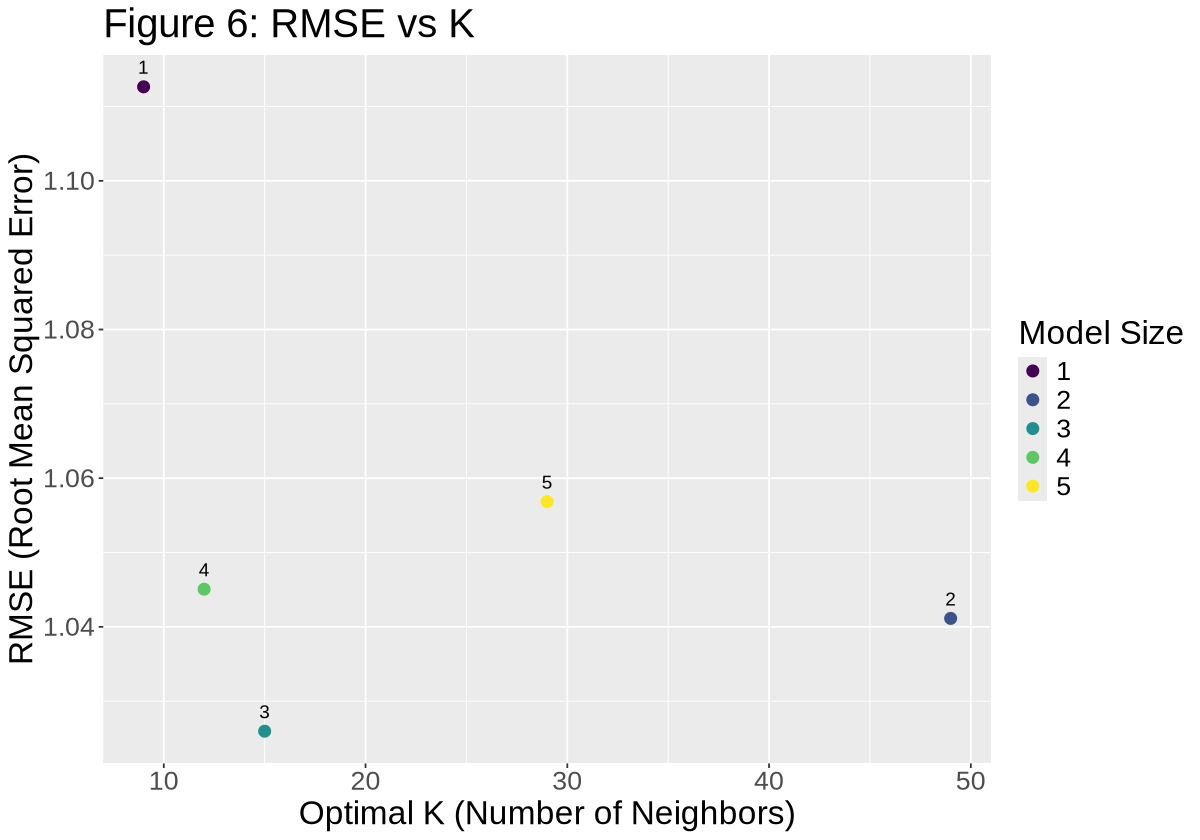

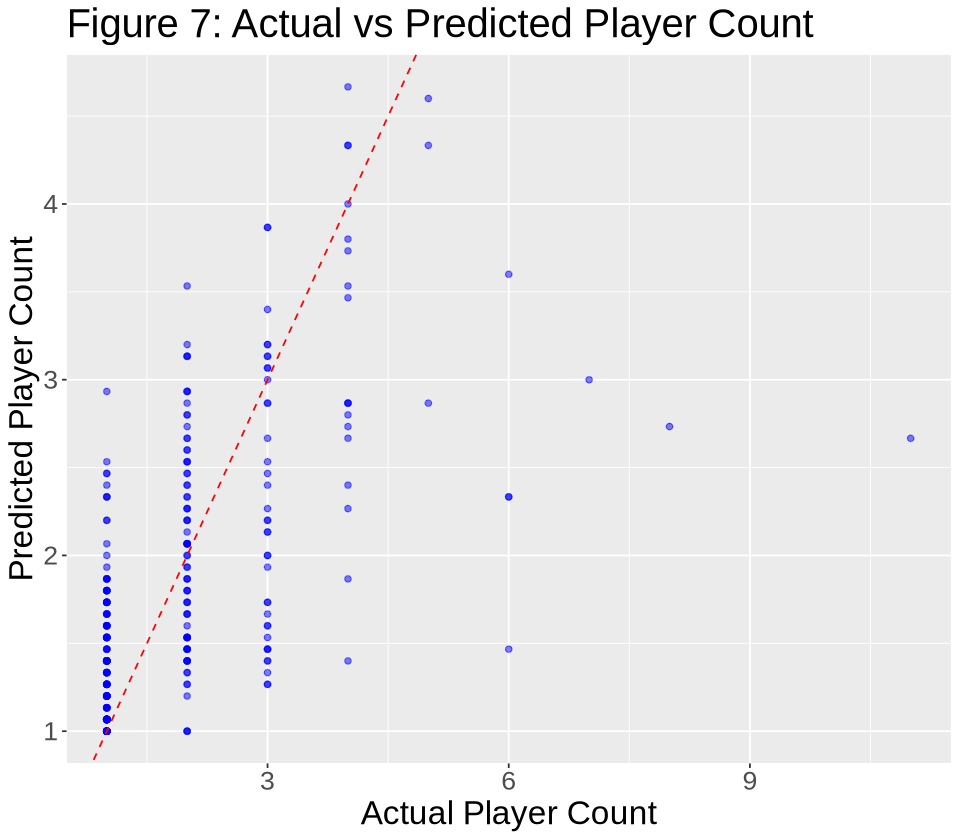

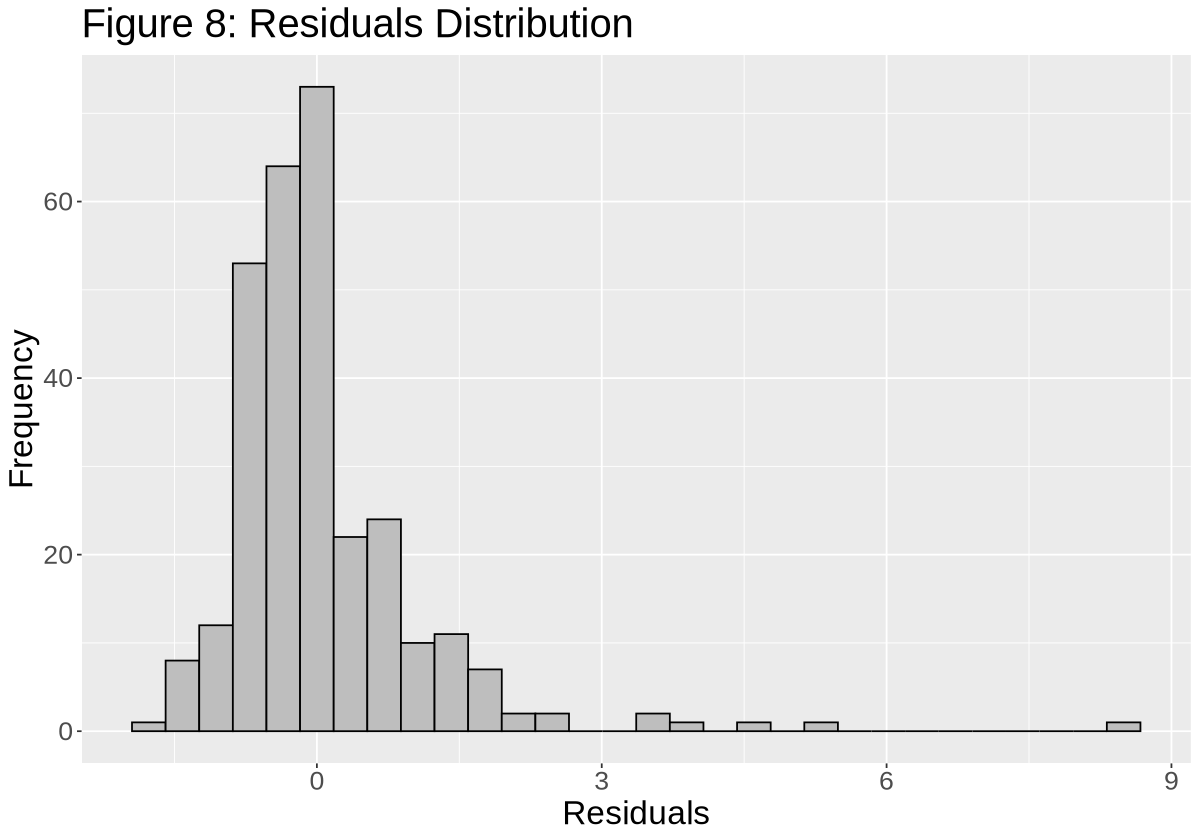

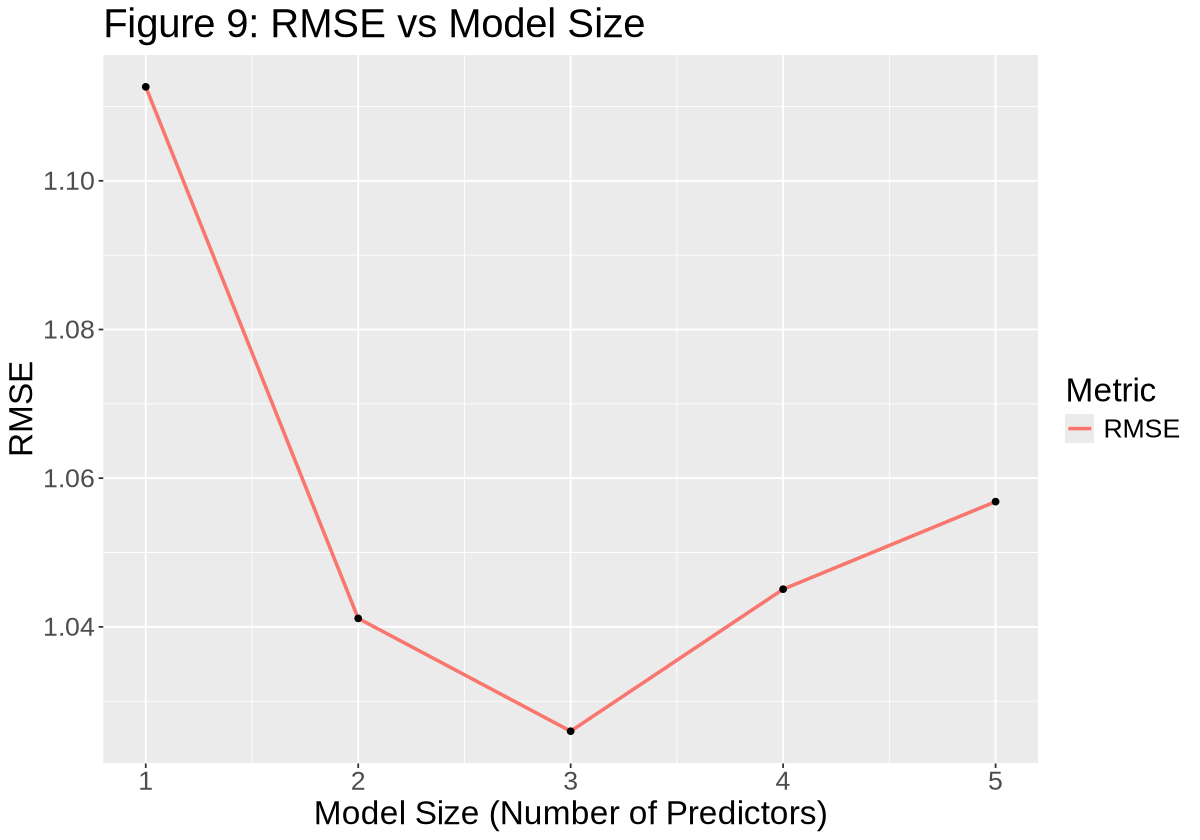

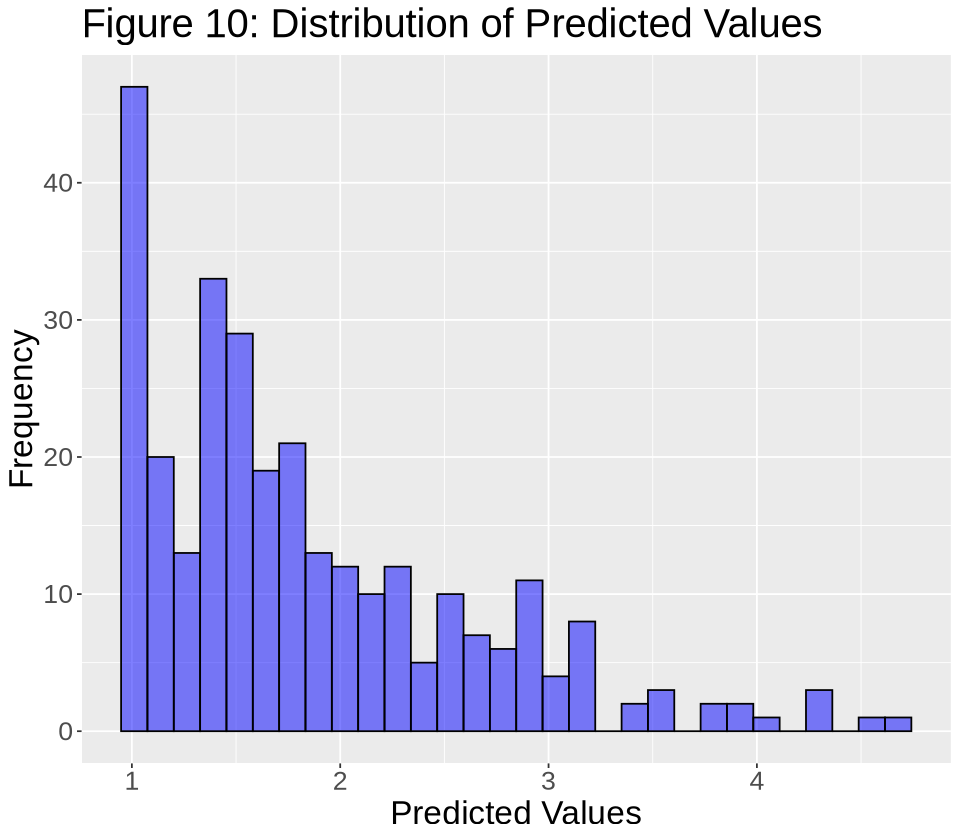

In [39]:
results <- forward_selection_results |> 
  select(size, rmspe, best_k)  # Select relevant columns from the forward_selection_results

options(repr.plot.width = 10, repr.plot.height = 7)

# RMSE vs K plot (visualizing RMSPE vs best_k)
ggplot(results, aes(x = best_k, y = rmspe, label = size)) +
  geom_point(aes(color = factor(size)), size = 3) +  
  geom_text(vjust = -1, hjust = 0.5, size = 4) +  
  labs(
    title = "Figure 6: RMSE vs K", 
    x = "Optimal K (Number of Neighbors)", 
    y = "RMSE (Root Mean Squared Error)",
    color = "Model Size"
  ) +
  theme(
    text = element_text(size = 20),
  ) +
  scale_color_viridis_d()

actual_vs_predicted <- tibble(
  actual = final_knn_preds$player_count, 
  predicted = final_knn_preds$.pred
)

options(repr.plot.width = 8, repr.plot.height = 7)
# Plot Actual vs Predicted
ggplot(actual_vs_predicted, aes(x = actual, y = predicted)) +
  geom_point(color = "blue", alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") + 
  labs(
    title = "Figure 7: Actual vs Predicted Player Count", 
    x = "Actual Player Count", 
    y = "Predicted Player Count"
  ) +
  theme(
    text = element_text(size = 20),
    plot.caption = element_text(hjust = 0)
  )  

# Calculate residuals
residuals <- final_knn_preds$player_count - final_knn_preds$.pred

options(repr.plot.width = 10, repr.plot.height = 7)
# Plot residuals
ggplot(tibble(residuals), aes(x = residuals)) +
  geom_histogram(bins = 30, fill = "gray", color = "black") +
  labs(
    title = "Figure 8: Residuals Distribution", 
    x = "Residuals", 
    y = "Frequency"
  ) +
  theme(
    text = element_text(size = 20),
    plot.caption = element_text(hjust = 0)
  )

# Model Performance vs Model Size/Complexity plot
options(repr.plot.width = 10, repr.plot.height = 7)
ggplot(forward_selection_results, aes(x = size, y = rmspe)) +
  geom_line(aes(color = "RMSE"), linewidth = 1) +
  geom_point() +
  labs(
    title = "Figure 9: RMSE vs Model Size",
    x = "Model Size (Number of Predictors)",
    y = "RMSE",
    color = "Metric"
  ) +
  theme(text = element_text(size = 20))

# Distribution of predicted values
options(repr.plot.width = 8, repr.plot.height = 7)
ggplot(final_knn_preds, aes(x = .pred)) +
  geom_histogram(bins = 30, fill = "blue", color = "black", alpha = 0.5) +
  labs(
    title = "Figure 10: Distribution of Predicted Values",
    x = "Predicted Values",
    y = "Frequency"
  ) +
  theme(text = element_text(size = 20))

# Discussion

The objective of this analysis was to develop a model to predict the number of simultaneous players using various predictors, such as month, day of week, hour, player experience, and session duration. After performing forward selection and evaluating multiple models, we determined that the optimal model for predicting player count uses **total_session_duration**, **most_frequent_experience**, and **hour** as predictors, with an optimal **K** value of **15**.

The model's performance, as measured by **Root Mean Squared Error (RMSE)**, yielded a value of **1.03**, indicating that the model fits the data reasonably well for practical applications, such as predicting server load during peak times. The **Mean Absolute Error (MAE)** was **0.633**, reflecting the model's overall accuracy in predicting player counts with minor average errors. However, the **R-squared** value of **0.358** suggests that only **35.8%** of the variance in player count is explained by the model, leaving a significant portion of variability unaccounted for.

The performance of the model aligns with our initial expectations. While the **RMSE** and **MAE** indicate good predictive accuracy, the **R-squared** value highlights the need for additional features or more sophisticated modeling approaches to better capture the variance in player counts. The relatively low **R-squared** points to the complexity of player behavior, which may be influenced by factors not included in the model.

The findings from this model have several implications for operational planning. The model can be valuable in predicting player counts and assisting with resource allocation, such as server capacity management during peak usage times. However, the moderate **R-squared** value indicates that the model's ability to generalize, particularly for extreme player counts, is limited. This suggests that while the model is useful for smaller, more predictable player counts, it may not perform as well for large outliers.

Several future questions arise from these findings. What other modeling techniques, such as **Random Forests** or **Gradient Boosting**, could offer improved predictive accuracy by capturing more complex relationships between predictors and player count? Could additional features, such as **time zone**, **geographic location**, or **player engagement metrics**, enhance the model’s accuracy in predicting player counts? What factors contribute to the outliers in player counts, and how might these be addressed? For example, could special events, deadlines, or specific user behavior such as Discord activity or the DSCI 100 playtime participation deadline explain these anomalies?

The results from the analysis were visualized through several plots, providing insights into the model's behavior and performance. 

**Figure 6: RMSE vs K** shows the relationship between the number of predictors and the **RMSE** for different values of **K**. The plot suggests there is a balance between **RMSE** and the number of predictors, with the best model achieved at **Model Size 3** with **K = 15** based on RMSE.

**Figure 7: Actual vs Predicted Player Count** compares actual player counts with the model's predictions. The red dashed line represents the ideal prediction, where the predicted value perfectly matches the actual value. While the model performs well for lower player counts, it tends to underestimate higher player counts, indicating that the model struggles with more extreme values and potential outliers. This suggests that while the model is suitable for predicting common player counts, its accuracy diminishes when handling larger player activities.

**Figure 8: Residuals Distribution** illustrates the distribution of residuals, or the difference between actual and predicted player counts. The residuals are mostly centered around zero, which indicates that the model's predictions are generally accurate. However, there are a few outlier residuals, suggesting that the model occasionally underestimates player counts, particularly for certain instances.

**Figure 9: RMSE vs Model Size** displays how **RMSE** changes as more predictors are added to the model. The plot indicates that **Model Size 3** provides the best trade-off between model complexity and predictive performance. Adding more predictors beyond this point results in overfitting, as evidenced by the increase in **RMSE**. 

**Figure 10: Distribution of Predicted Values** demonstrates that the model predicts lower player counts more frequently, with most predictions concentrated between 1 and 2 players. The frequency of predictions decreases sharply for higher player counts, which indicates that the model performs better for smaller player counts and struggles with larger, less frequent player activities.

Ultimately, the KNN regression model offers a reasonable starting point for predicting player counts, but its moderate **R-squared** value suggests that additional data and improved modeling techniques are needed to fully capture the complexity of player behavior. Future work could explore alternative models, incorporate more features, and address the presence of outliers to improve the model's accuracy and generalizability.